## RD900 region - identification of duplication events in MTBC

**Objective:**

Identify duplication events in RD900 MTBC using available genome assemblies.

**Method:**

1. identify assemblies to use including sub-sampling MTB an Mbovis genomes by choosing best qualities
2. decide which sub sequences we want to use to detect presence of a gene in contigs
3. for each assembly:
    * make a blast database
    * blast sub-sequence(s) to it
    * store result
4. make a matrix of presence absence for each genome
5. make a species tree and use the matrix to determine parsimony

**Links:**

* https://github.com/dmnfarrell/rd900


<img src="img/pknh_orthologs.png" width=500></img>

In [130]:
import os, glob, subprocess
import urllib
from importlib import reload
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from BCBio import GFF
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import tools

In [62]:
#samples = pd.read_csv('genomes_data.csv')
assemblies = pd.read_csv('mtb_assemblies.csv')

### Filter assemblies to use

In [ ]:
filtered=assemblies[(assemblies.Level=='Complete Genome') | (~assemblies.species.isin(['mtb','bovis','H37Rv']))]
#filtered.Scaffolds.hist(bins=20,lw=1)
#plt.title('no. of scaffolds distr')
print (len(filtered),len(assemblies))
print (filtered.species.value_counts())
filtered[:5]

### test data fetch

In [6]:
url = assemblies.loc[0]['GenBank FTP']
link = tools.get_url_from_path(url)
name = 'GCA_000934325.3'
urllib.request.urlretrieve(link, os.path.join('assemblies', name+'.fa.gz'))

('assemblies/GCA_000934325.3.fa.gz', <email.message.Message at 0x7fe684327400>)

### make local blast database

In [9]:
def make_blast_db(infile, out='test'):
    
    cmd = 'gunzip -c {i} | makeblastdb -in - -dbtype nucl -out blastdb/{o} -title test'.format(i=infile,o=out)
    subprocess.check_output(cmd, shell=True)
    return

make_blast_db('assemblies/GCA_000934325.3.fa.gz')

### determine sequences to blast using sub sequences within africanum RD900 region

In [132]:
rd900seq = SeqIO.read('RD900MAF.fa',format='fasta')
tbd2 = rd900seq[2907:5303]
tbd2.id = 'tbd2'
pknh2 = rd900seq[5314:6981]
pknh2.id='pknh2'
pro1 = rd900seq[1612:1772]
pro1.id = 'pknh1-proregion'
pknh2_sensor = rd900seq[5314:6000]
pknh2_sensor.id = 'pknh2_sensor'
print (pknh2_sensor.seq)

TACCCGTACTTGGCCCACCAGTTGTGCAGATCCTCAATGGTCGCGGGATCCCCGAAGACGTCGCTGAGCGTTAGCTTGGCCTCGTTGCTCCAGATCACGTTCGGGCGATTCTTATAGGTGCCGCACGCGATCATGCCTGCGGTCACGTCTGGGGTCTGGTTGTAATGCCAGCCATCCGGTGATGGTCCTTCACCGGGACAGTTCATCAGCTCCACGGCGGCGATATCGTCGTTGAAGGCCTGTTTCAGCTTGTCGGGATTGGCGAACAATCCATAGATGGCGCGACTTGGCCCACCCTGGTTGGTGTTTTGCCCGCAGTCGACCATCGCCACGGCGTTCACCCATATGCTGTTCGGCTTCGGCGTGGTCGGTTTACAGGTGCCGGTCGGATAGCCCGACGGCAACATGCTGAGCAGCCTGGTCTGCGGGTCGCTGGCCGGTGCTGTGGTCGGCGTTGTGGTCGCGGGTAGCGAGGTCGTTGCCGTGGTGGTGGGGGTGCCTGGGGAGGTCGCGATGTTCCGTTTTGGGTTGTCGTCCGGTCGGTTGGCGATCCAGATGCCGATGGCGCCCAACACGAGGACGAGCACGACGGCGGCGGCGACGGCCACAAAGGGCCACGGGTTCGTTTTGCGTGGGGTCTGGGCCCAGGGGCTGGGGCCGCCGGACGGCGGTGCGCCCCAGCCGCC


### loop over assemblies and get results

Here we loop over each assembly in the table and fetch the file remotely, make a blast db and 

In [139]:
def run(seqs):
    result=[]
    for i,row in filtered[:80].iterrows():
        acc = row.Assembly
        strain = row.Strain
        species = row.species
        full = row.Organism_Name
        print (strain, acc)
        url = row['GenBank FTP']
        #get file
        dbname = 'blastdb/%s.nsq' %acc
        if not os.path.exists(dbname):
            link = tools.get_url_from_path(url)
            filename = os.path.join('assemblies', acc+'.fa.gz')
            urllib.request.urlretrieve(link, filename)
            #make blast database for this genome
            make_blast_db(filename, out=acc)
        data={}
        for seq in seqs:
            #do blast
            bl = tools.blast_sequences('blastdb/%s' %acc, seq)
            bl['pcov'] = bl.length/len(seq)
            #print (bl)
            bl = bl[bl.pcov>.50]
            if len(bl)>0:
                x = bl.iloc[0]                
                ident = x.pident
            else:
                ident = 0
            data[seq.id] = ident
        data['id'] = acc
        data['strain'] = strain
        data['species'] = species
        data['name'] = full
        result.append(data)

    result = pd.DataFrame(result)#,columns=['id','strain','species','name','tbd2'])
    return result 

seqs = [tbd2,pro1,pknh2_sensor]
result = run(seqs)
result.to_csv('region_results.csv',index=False)

SP38 GCA_000934325.3
H37Rv GCA_000195955.2
UT307 GCA_001593225.1
ATCC 19422 GCA_002982215.1
Allgaeu GCA_001941665.1
ATCC BAA-688 GCA_002982275.1
MP2 GCA_003027795.2
MB2 GCA_001369315.1
12 GCA_001544815.1
MAL010084 GCA_000666065.1
AF2122/97 GCA_000195835.2
1595 GCA_001078615.1
BCG-1 (Russia) GCA_001483905.1
CDC1551 GCA_000008585.1
MAL020148 GCA_000666125.1
ATCC BAA-824 GCA_002982225.1
MP1 GCA_003027895.2
ATCC 25420 GCA_002982335.1
BCG Pasteur 1173P2 GCA_000009445.1
2002/0476 GCA_002975475.1
Danish delta-sapM GCA_005155785.1
Tokyo 172 GCA_000010685.1
25 GCA_001544855.1
H37Ra; ATCC 25177 GCA_000016145.1
Danish 1331 GCA_005156105.1
F11 GCA_000016925.1
KZN 1435 GCA_000023625.1
Haarlem GCA_000153685.2
KZN 4207 GCA_000154585.2
KZN 605 GCA_000154605.2
W-148 GCA_000193185.2
63839 GCA_000194075.3
CTRI-2 GCA_000224435.1
Mexico GCA_000234725.1
GM041182 GCA_000253355.1
CCDC5180 GCA_000270365.1
H37Rv GCA_000277735.2
7199-99 GCA_000331445.1
Korea 1168P GCA_000338715.2
Erdman (ATCC35801) GCA_000350205

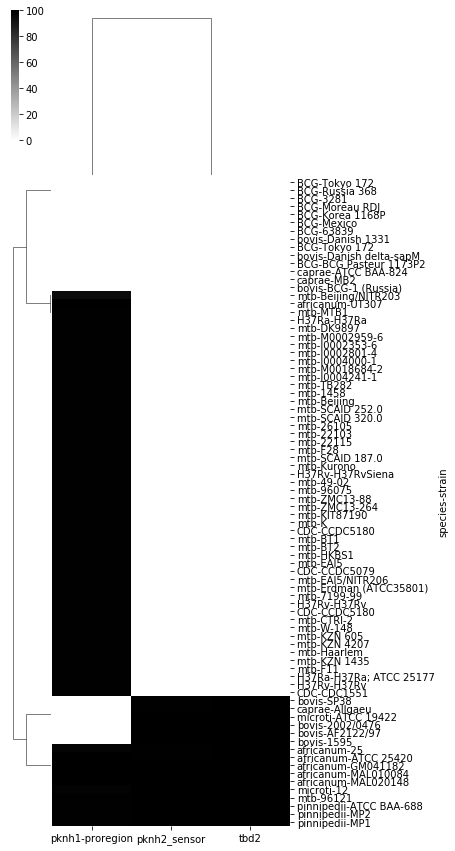

In [142]:
X=result.set_index(['species','strain']).drop(columns=['name','id'])
sns.clustermap(X,cmap='gray_r',yticklabels=1,figsize=(5,15))